In [1]:

from __future__ import annotations
import os
import json
from collections import Counter
from typing import List, Dict, Tuple
from collections import defaultdict
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from catboost import CatBoostRegressor
import joblib
from ast import literal_eval
from scipy.stats import normaltest


from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# -----------------------------
# Конфиг
# -----------------------------
ARTIFACT_DIR = os.environ.get("ARTIFACT_DIR", "to_Deploy")
JOBLIB_DIR = os.path.join(ARTIFACT_DIR, "joblib")
TOP_SKILLS_N = 30
TEST_SIZE = 0.20
RANDOM_STATE = 42

# Параметры CatBoost (подобранные через Optuna)

CAT_PARAMS_NO_VAC ={'iterations': 956,
                    'learning_rate': 0.02732361681926645, 
                    'depth': 10, 
                    'l2_leaf_reg': 7.899511609358967, 
                    'random_strength': 7.937743579871258, 
                    'bagging_temperature': 0.07856525216914066,
                    'border_count': 135,
                    'min_data_in_leaf': 48, 
                    'grow_policy': 'Lossguide',
                    'random_seed': RANDOM_STATE,
                    'verbose': 100
                    }

# -----------------------------
# Утилиты
# -----------------------------

def ensure_dirs():
    os.makedirs(ARTIFACT_DIR, exist_ok=True)
    os.makedirs(JOBLIB_DIR, exist_ok=True)


def safe_literal_eval(x):
    """Безопасное преобразование строки в список."""
    if isinstance(x, list):
        return x
    elif isinstance(x, str):
        try:
            return literal_eval(x)
        except:
            return np.nan
    else:
        return np.nan


def filtered_skills_top_n(df_in: pd.DataFrame, n: int) -> pd.DataFrame:
    """Оставляем только топ-n самых частых mapped_skills внутри каждой позиции."""
    df = df_in.copy()
    if 'mapped_skills' not in df.columns:
        raise KeyError("mapped_skills column is required")
    for pos in df['position'].dropna().unique():
        mask = df['position'] == pos
        skills_lists = df.loc[mask, 'mapped_skills']
        all_skills = [s for lst in skills_lists for s in (lst or [])]
        cnt = Counter(all_skills)
        top = set([s for s, _ in cnt.most_common(n)])
        df.loc[mask, 'mapped_skills'] = skills_lists.apply(lambda lst: [s for s in (lst or []) if s in top])
    return df

# Функция очистки и нормализации
def process_series(series, colname, position):
    series = pd.to_numeric(series, errors='coerce')
    series = series.dropna()
    n_total = len(series)
    if len(series) < 20:
        return series

    stat, p = normaltest(series)
    is_normal = p > 0.05

    if is_normal:
        mu, sigma = series.mean(), series.std()
        mask = (series >= mu - 3 * sigma) & (series <= mu + 3 * sigma)
    else:
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        mask = (series >= q1 - 1.5 * iqr) & (series <= q3 + 1.5 * iqr)

    n_filtered = mask.sum()
    n_removed = n_total - n_filtered


    return series[mask]


def clean_targets_by_position(df_in: pd.DataFrame) -> pd.DataFrame:
    """Очистка и нормализация таргетов salary по позициям."""
    df = df_in.copy()
    
    # Создаем новые колонки для нормализованных значений
    df['salary_from_norm'] = np.nan
    df['salary_to_norm'] = np.nan
    
    positions = df['position'].dropna().unique()
    
    if 'salary from' in df.columns:
        for pos in positions:
            m = df['position'] == pos
            s = process_series(df.loc[m, 'salary from'], 'salary from', pos)
            if s is not None and len(s) > 0:
                df.loc[s.index, 'salary_from_norm'] = s
    
    if 'salary to' in df.columns:
        for pos in positions:
            m = df['position'] == pos
            s = process_series(df.loc[m, 'salary to'], 'salary to', pos)
            if s is not None and len(s) > 0:
                df.loc[s.index, 'salary_to_norm'] = s
    
    # Оставляем только строки, где есть хотя бы одна нормализованная зарплата
    has_from = df['salary_from_norm'].notna()
    has_to = df['salary_to_norm'].notna()
    df = df[has_from | has_to].copy()
    
    return df


def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """Создание финальных признаков (порядковое кодирование)."""
    experience_order = {
        'Нет опыта': 0,
        '1–3 года': 1,
        '3–6 лет': 2,
        'Более 6 лет': 3,
        'Unknown': -1
    }
    level_order = {
        'Trainee': 0,
        'Junior': 1,
        'Middle': 2,
        'Senior': 3,
        'Lead': 4,
        'Chief': 5,
        'Unknown': -1
    }
    df['experience_ord'] = df['experience'].map(experience_order).fillna(-1).astype(int)
    df['level_ord'] = df['level'].map(level_order).fillna(-1).astype(int)
    return df


def build_encoders(df: pd.DataFrame) -> Tuple[OneHotEncoder, MultiLabelBinarizer]:
    """Фитим OHE для категориальных (без experience и level) и MLB для mapped_skills."""
    cat_cols = ['position', 'schedule', 'employment', 'region']
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ohe.fit(df[cat_cols])

    mlb = MultiLabelBinarizer()
    mlb.fit(df['mapped_skills'])
    return ohe, mlb

def build_encoders_2(df: pd.DataFrame) -> Tuple[OneHotEncoder, MultiLabelBinarizer]:
    """Фитим OHE для категориальных (c experience и level) и MLB для mapped_skills."""
    cat_cols = ['position', 'schedule', 'employment', 'region', 'experience_ord', 'level_ord']
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ohe.fit(df[cat_cols])

    mlb = MultiLabelBinarizer()
    mlb.fit(df['mapped_skills'])
    return ohe, mlb


def transform_features(df: pd.DataFrame, ohe: OneHotEncoder, mlb: MultiLabelBinarizer) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """Преобразование признаков в матрицу (OHE + ord + MLB)."""
    cat_cols = ['position', 'schedule', 'employment', 'region']
    ord_cols = ['experience_ord', 'level_ord']
    X_ohe = ohe.transform(df[cat_cols])
    X_ord = df[ord_cols].values
    X_mlb = mlb.transform(df['mapped_skills'])
    #X = np.hstack([X_ohe, X_mlb])
    X = np.hstack([X_ohe, X_ord, X_mlb])
    #feature_names = list(ohe.get_feature_names_out(cat_cols)) + list(mlb.classes_)
    feature_names = list(ohe.get_feature_names_out(cat_cols)) + ord_cols + list(mlb.classes_)
    return X, X_mlb, feature_names


def stratified_split(X: np.ndarray, y: pd.Series, df_positions: pd.Series, test_size: float = TEST_SIZE):
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=RANDOM_STATE)
    for tr_idx, te_idx in splitter.split(X, df_positions):
        return tr_idx, te_idx
    raise RuntimeError("Ошибка разбиения выборки")


def train_cb(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray) -> CatBoostRegressor:
    """Обучение модели CatBoost."""
    # Убедимся, что нет NaN в целевой переменной
    mask_train = ~np.isnan(y_train)
    mask_val = ~np.isnan(y_val)
    
    X_train_clean = X_train[mask_train]
    y_train_clean = y_train[mask_train]
    X_val_clean = X_val[mask_val]
    y_val_clean = y_val[mask_val]
    
    model = CatBoostRegressor(task_type='GPU',**CAT_PARAMS_NO_VAC)
    model.fit(
        X_train_clean,
        y_train_clean,
        eval_set=(X_val_clean, y_val_clean),
        use_best_model=True,
        early_stopping_rounds=100,
        verbose=100,
    )
    return model


def evaluate(model: CatBoostRegressor, X_test: np.ndarray, y_test: np.ndarray, tag: str = "") -> Dict[str, float]:
    """Оценка качества модели."""
    # Убедимся, что нет NaN в тестовых данных
    mask = ~np.isnan(y_test)
    if mask.sum() == 0:
        return {"tag": tag, "MAE": float('nan'), "R2": float('nan'), "MAPE": float('nan')}
    
    X_test_clean = X_test[mask]
    y_test_clean = y_test[mask]
    
    y_pred = model.predict(X_test_clean)
    return {
        "tag": tag,
        "MAE": float(mean_absolute_error(y_test_clean, y_pred)),
        "R2": float(r2_score(y_test_clean, y_pred)),
        "MAPE": float(mean_absolute_percentage_error(y_test_clean, y_pred)),
    }



def save_top_skills_by_position(model, mlb, df, filename="top_skills_by_position.json", top_n=30):
    """Сохраняем топ-N скиллов по каждой позиции."""
    feature_importances = model.get_feature_importance(type="FeatureImportance")
    feature_names = model.feature_names_


    skills_importances = {name: imp for name, imp in zip(feature_names, feature_importances) if name in mlb.classes_}
    skills_sorted = sorted(skills_importances.items(), key=lambda x: x[1], reverse=True)


    result = {}
    for pos in df['position'].unique():
        result[pos] = [skill for skill, _ in skills_sorted[:top_n]]


    with open(filename, "w", encoding="utf-8") as f:
        json.dump(result, f, ensure_ascii=False, indent=2)


def save_manifest(ohe, mlb, filename="columns_manifest.json"):
    """Сохраняем описание порядка признаков."""
    manifest = {
    "categorical_features": list(ohe.get_feature_names_out()),
    "ordinal_features": ["experience_ord", "level_ord"],
    "skills_features": list(mlb.classes_),
    "description": "Порядок признаков: сначала категориальные (OHE), затем порядковые (experience_ord, level_ord), затем бинаризация skills"
    }
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(manifest, f, ensure_ascii=False, indent=2)
        
def save_filter_options(df: pd.DataFrame, filename="filter_options.json"):
    """Сохраняем доступные фильтры для фронта из реальных данных."""
    # Берем уникальные значения из данных, исключая NaN
    options = {
        "experience": sorted(df['experience'].dropna().unique().tolist()),
        "schedule": sorted(df['schedule'].dropna().unique().tolist()),
        "employment": sorted(df['employment'].dropna().unique().tolist()),
        "level": sorted(df['level'].dropna().unique().tolist()),
        "region": sorted(df['region'].dropna().unique().tolist()),
        "position": sorted(df['position'].dropna().unique().tolist())
    }
    
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(options, f, ensure_ascii=False, indent=2)
        
def save_top_skills_by_position_separate_models(df: pd.DataFrame, filename: str, top_n: int = 30):
    """Сохраняем топ-N скиллов по каждой позиции, обучая отдельные модели."""
    
    # Основные категориальные признаки (без position, так как мы уже фильтруем по ней)
    cat_features = ['experience', 'schedule', 'employment', 'level', 'region']
    skill_feature = 'mapped_skills'
    
    # Словарь для хранения топ-скиллов
    top_skills_per_position = defaultdict(list)
    
    for pos in tqdm(df['position'].unique(), desc="Processing positions"):
        try:
            # Фильтруем данные по позиции
            df_pos = df[df['position'] == pos].copy()
            
            if len(df_pos) < 30:  # Минимальное количество samples для обучения
                print(f"⚠️  Пропускаем позицию {pos}: слишком мало данных ({len(df_pos)})")
                continue
            
            # Признаки и цель (используем нормализованную зарплату)
            X = df_pos[cat_features + [skill_feature]]
            y = df_pos['salary_from_norm']
            
            # Удаляем строки с NaN в целевой переменной
            valid_mask = ~y.isna()
            X = X[valid_mask]
            y = y[valid_mask]
            
            if len(X) < 20:  # Проверяем после фильтрации
                print(f"⚠️  Пропускаем позицию {pos}: мало данных после фильтрации ({len(X)})")
                continue
            
            # Кодирование
            ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
            mlb = MultiLabelBinarizer()
            
            # Кодируем категориальные признаки
            X_cat_encoded = ohe.fit_transform(X[cat_features])
            
            # Кодируем скиллы
            X_skills_encoded = mlb.fit_transform(X[skill_feature])
            
            # Объединяем признаки
            X_final = np.hstack([X_cat_encoded, X_skills_encoded])
            
            # Разделение на train/test
            X_train, X_test, y_train, y_test = train_test_split(
                X_final, y, test_size=0.2, random_state=RANDOM_STATE
            )
            
            # Параметры CatBoost для отдельных моделей
            catboost_params = {
                'iterations': 500,
                'learning_rate': 0.05,
                'depth': 6,
                'l2_leaf_reg': 3,
                'random_strength': 1,
                'verbose': False,
                'random_seed': RANDOM_STATE
            }
            
            # Обучение CatBoost
            model = CatBoostRegressor(**catboost_params)
            model.fit(X_train, y_train)
            
            # Получаем важности признаков
            importances = model.get_feature_importance()
            
            # Список всех признаков
            ohe_features = ohe.get_feature_names_out(cat_features)
            skill_features = mlb.classes_
            all_feature_names = list(ohe_features) + list(skill_features)
            
            # Создаем DataFrame с важностями
            feat_df = pd.DataFrame({
                'feature': all_feature_names,
                'importance': importances
            })
            
            # Отбираем только скиллы
            skill_df = feat_df[feat_df['feature'].isin(skill_features)]
            top_skills = skill_df.sort_values(by='importance', ascending=False)
            
            # Сохраняем топ-скиллы
            top_skills_per_position[pos] = top_skills['feature'].head(top_n).tolist()
            
            print(f"✅ Позиция {pos}: обработано {len(X)} samples, найдено {len(top_skills)} скиллов")
            
        except Exception as e:
            print(f"❌ Ошибка при обработке позиции {pos}: {e}")
            continue
    
    # Сохраняем в JSON
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(top_skills_per_position, f, ensure_ascii=False, indent=2)
    
    return top_skills_per_position


# -----------------------------
# Основной пайплайн обучения
# -----------------------------

def run_training(df: pd.DataFrame) -> Dict[str, Dict[str, float]]:
    ensure_dirs()

    # 1) Преобразуем mapped_skills в список
    df['mapped_skills'] = df['mapped_skills'].apply(safe_literal_eval)
    
    allowed_positions = [
    "Аналитик",
    "Бизнес-аналитик",
    "Дизайнер, художник",
    "Продуктовый аналитик",
    "Руководитель проектов",
    "Сетевой инженер",
    "Системный администратор",
    "Специалист по информационной безопасности",
    "Специалист технической поддержки",
    "Технический писатель"
]
    
    df = df[df['position'].isin(allowed_positions)]

    # 2) Оставляем только топ-30 скиллов в каждой позиции
    df1 = filtered_skills_top_n(df, TOP_SKILLS_N)
    df1 = df1[df1['mapped_skills'].apply(lambda x: isinstance(x, list) and len(x) > 0)].copy()

    # 3) Очистка таргетов по позициям
    df2 = clean_targets_by_position(df1)

    # 4) Добавляем порядковые признаки experience_ord и level_ord
    df2 = create_features(df2)

    # 5) Фитим энкодеры
    ohe, mlb = build_encoders(df2)

    # 6) Преобразуем признаки
    X_all, X_skills, feature_names = transform_features(df2, ohe, mlb)

     # 7) Разбиваем на train/test (стратификация по position)
    tr_idx, te_idx = stratified_split(X_all, df2['salary_from_norm'], df2['position'])

    artifacts = {}

    # Обучение salary_from
    y_from = df2['salary_from_norm'].values
    model_from = train_cb(X_all[tr_idx], y_from[tr_idx], X_all[te_idx], y_from[te_idx])
    metrics_from = evaluate(model_from, X_all[te_idx], y_from[te_idx], tag='salary_from')
    artifacts['salary_from'] = metrics_from

    # Обучение salary_to
    y_to = df2['salary_to_norm'].values
    valid_to = ~pd.isna(y_to)
    tr_to = np.intersect1d(np.where(valid_to)[0], tr_idx)
    te_to = np.intersect1d(np.where(valid_to)[0], te_idx)

    model_to = train_cb(X_all[tr_to], y_to[tr_to], X_all[te_to], y_to[te_to])
    metrics_to = evaluate(model_to, X_all[te_to], y_to[te_to], tag='salary_to')
    artifacts['salary_to'] = metrics_to

    # Сохраняем модели и энкодеры
    joblib.dump(model_from, os.path.join(JOBLIB_DIR, 'cb_model_from.joblib'))
    joblib.dump(model_to,   os.path.join(JOBLIB_DIR, 'cb_model_to.joblib'))
    joblib.dump(ohe,        os.path.join(JOBLIB_DIR, 'ohe_encoder.joblib'))
    joblib.dump(mlb,        os.path.join(JOBLIB_DIR, 'mlb_encoder.joblib'))
    
    # Сохраняем топ скиллы по позициям и манифест
    #save_top_skills_by_position(model_from, mlb, df2, filename=f"{ARTIFACT_DIR}/top_skills_by_position.json", top_n=30)
    top_skills = save_top_skills_by_position_separate_models(
        df2, 
        filename=os.path.join(ARTIFACT_DIR, "top_skills_by_position.json"), 
        top_n=30
    )
    
    save_manifest(ohe, mlb, filename= os.path.join(ARTIFACT_DIR, "columns_manifest.json"))
    save_filter_options(df2, filename=os.path.join(ARTIFACT_DIR, 'filter_options.json'))

    return artifacts




In [3]:
df_train_result = pd.read_csv('data/df_train_result_from_eda_2.csv')

In [4]:
df_train_result['mapped_skills'] = df_train_result['mapped_skills'].apply(safe_literal_eval)

In [5]:
from collections import OrderedDict

skill_mapping = {
    "Дизайнер, художник": {
        "PHOTOSHOP": "Adobe Photoshop",
        "MS Office Word, Excel, Power Point, Outlook": "Microsoft Office Word, Excel",
        "знание программы CorelDRAW":"CorelDRAW",
        "COREL":"CorelDRAW",
        "Adobe Creative Suite Photoshop, Illustrator, InDesign, After Effects": "Adobe Creative Suite",
        "Adobe Creative Cloud: Photoshop, Illustrator, InDesign, After Effects, Power Point": "Adobe Creative Cloud",
        "2д анимация в Adobe After Effects":"2D анимация Adobe After Effects",
        "Adobe": "Adobe Creative Suite",
        "3d": "3D визуализация",
        "HTML/CSS/JS базовый уровень":"HTML/CSS/JS"
    },
    "Аналитик": {
        "Знание предметной области бухгалтерский и налоговый учет": "Бухгалтерский, оперативный и фин. учет",
        "1С:Управление торговлей":"1С:УТ",
        "MS Word": "MS Office",
        "MS Outlook": "MS Office",
        "Технические задания":"Составление ТЗ"
    },
    "Руководитель проектов":{
        "1С системы продажи, закупки, производство, выполнение работ": "1C",
        "MS Office Word": "MS Office",
        "MS Office Outlook": "MS Office",
        "MS Office Excel": "MS Office",
        "BPMN 2.0":"BPMN",
        "MS Office Outlook":"MS Office"
    },
    "Менеджер продукта": {
        "Google Analytics": "GA"
    },
    "Методолог": {
        "уверенный пользователь ПК MS Office, Outlook, уверенное владение Excel": "Уверенный пользователь ПК (MS Office, Outlook Excel)",
        "опыт работы в учетных бухгалтерских системах SAP, 1C и других": "Опыт работы в Бух системах SAP, 1C и др"
    },
    "Программист, разработчик": {
        "1С: Бухгалтерия 3": "1С",
        "1c8": "1С"
    },
    "Продуктовый аналитик": {
        "Excel/Google Sheets": "Google Sheets"
    },
    "Системный администратор": {
        "Windows Server": "Microsoft Windows Server",
        "Windows": "Microsoft Windows",
        "Microsoft Office": "MS Office",
        "Active Directory": "MS ActiveDirectory",
        "Администрирование серверного оборудования под управлением ОС MS Windows Server 2008-2016 и OС Linux": "Microsoft Windows Server/Linux",
        "MS Office Word": "MS Office"
        
    },
    "Специалист по информационной безопасности": {
        "Windows/Linux": "Linux/Windows",
        "Windows Server": "Microsoft Windows Server"
    },
    "Специалист технической поддержки": {
        "работа в офисных программах и CRM": "CRM",
        "AD": "Active Directory",
        "Service/Help Desk": "HelpDesk/ServiceDesk",
        "MS Office Word": "MS Office",
        "Консультирование клиентов по продуктам \"1С": "Консультирование клиентов по продуктам 1С",
        "Командная строка windows":"CMD/PowerShell",
        "JIRA": "Jira"
    },
    "Сетевой инженер":{
        "стека протоколов TCP/IP": "Стек протоколов TCP/IP",
        "Сетевая модель OSI и модель TCP/IP":"OSI / TCP/IP",
        "сетевые протоколы и технологии L2/L3": "Протоколы и технологии L2/L3",
        "мониторинг работы сетевых устройств Eltex, Cisco": "Мониторинг работы сетевых устройств Eltex, Cisco",
        "Настройка и поддержка сетевого оборудования d-link, mikrotik, cisco, juniper": "Настройка и поддержка сетевого оборудования D-link, Mikrotik, Cisco, Juniper, Huawei",
        "Сетевое оборудование коммутаторы, маршрутизаторы": "Настройка и поддержка сетевого оборудования D-link, Mikrotik, Cisco, Juniper, Huawei",
        "IP":"Стек протоколов TCP/IP",
        "Работа с оборудованием вендоров Cisco, Juniper, Huawei": "Настройка и поддержка сетевого оборудования D-link, Mikrotik, Cisco, Juniper, Huawei",
        "Протоколы и технологии": "Протоколы и технологии L2/L3"
    },
    "Технический писатель":{
        "Microsoft Outlook": "MS Office",
        "Microsoft Word": "MS Office"
    }
}



def apply_position_mapping(row, mapping):
    position = row['position']
    skills = row['mapped_skills']

    if not isinstance(skills, list):
        return skills  # на всякий случай защита от кривых данных

    if position in mapping:
        mapped = [mapping[position].get(skill, skill) for skill in skills]
        # убираем дубликаты, но сохраняем порядок
        mapped = list(OrderedDict.fromkeys(mapped))
        return mapped
    
    return skills


df_train_result['mapped_skills'] = df_train_result.apply(
    lambda row: apply_position_mapping(row, skill_mapping),
    axis=1
)


In [6]:
# Функция для обработки списка скилов
def process_skills_list(skills_list):
    if not isinstance(skills_list, list):
        return skills_list
    
    # Удаляем 'anchor/Other' из списка
    filtered_skills = [skill for skill in skills_list if skill != 'anchor/Other']
    
    # Если список стал пустым после фильтрации, возвращаем None
    return filtered_skills if filtered_skills else None

# Применяем функцию к столбцу mapped_skills
df_train_result['mapped_skills'] = df_train_result['mapped_skills'].apply(process_skills_list)

# Удаляем строки, где mapped_skills is None (пустой список после удаления 'anchor/Other')
initial_count = len(df_train_result)
df_train_result = df_train_result[df_train_result['mapped_skills'].notna()]
final_count = len(df_train_result)

print(f"Удалено строк: {initial_count - final_count}")
print(f"Осталось строк: {final_count}")

Удалено строк: 4
Осталось строк: 17394


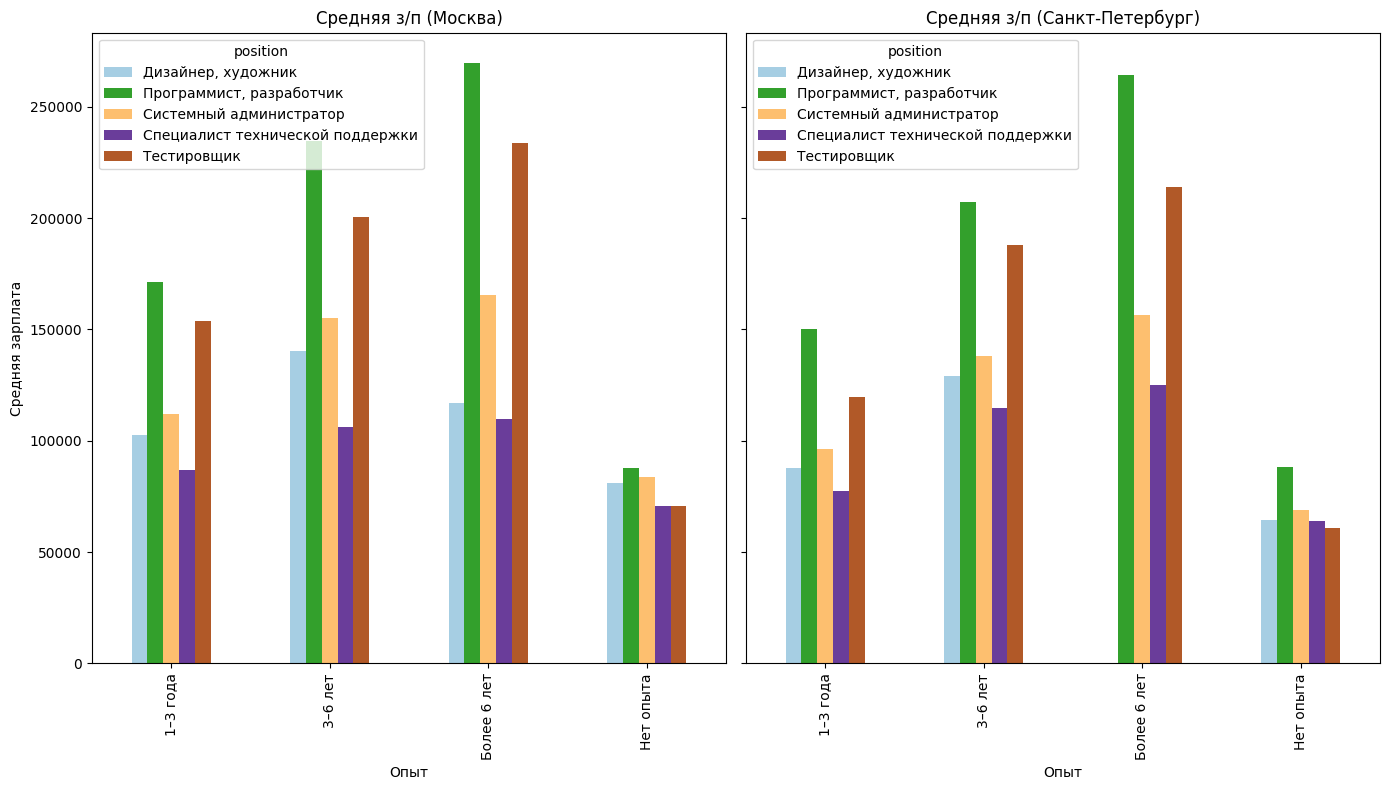

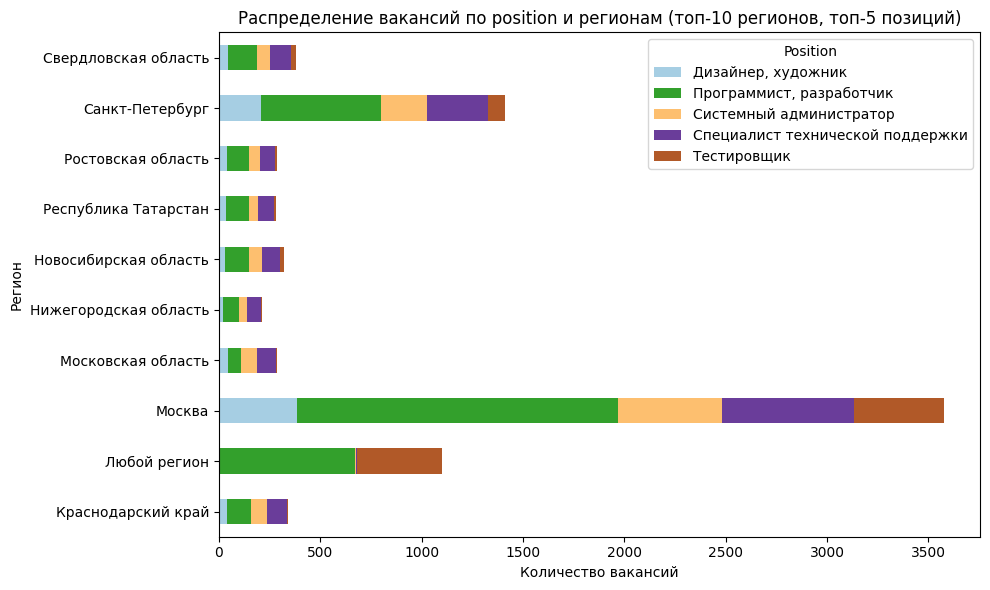

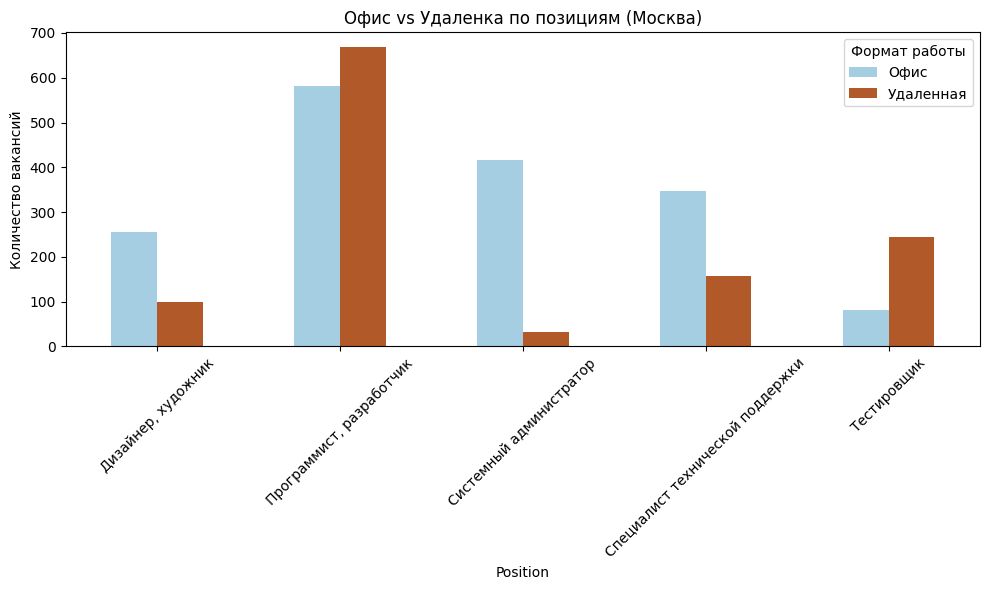

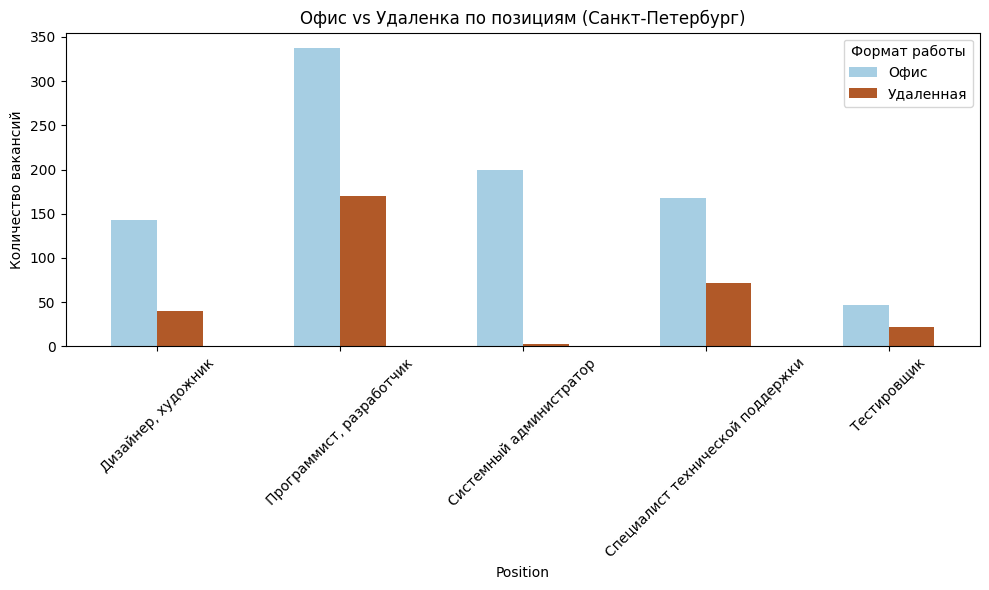

In [24]:
plot_job_market_stats(df_train_result)

In [ ]:
metrics = run_training(df_train_result)
print("\nФинальные метрики:")
for k, v in metrics.items():
    print(k, v)

0:	learn: 44430.0830276	test: 45827.3133112	best: 45827.3133112 (0)	total: 14ms	remaining: 13.4s
100:	learn: 22453.9290102	test: 22874.3518030	best: 22874.3518030 (100)	total: 1.28s	remaining: 10.9s
200:	learn: 21195.4562392	test: 22077.2797190	best: 22077.2797190 (200)	total: 2.38s	remaining: 8.95s
300:	learn: 20792.5442004	test: 21963.8292895	best: 21963.8292895 (300)	total: 3.22s	remaining: 7.01s
400:	learn: 20478.5914690	test: 21922.9659882	best: 21921.3915392 (398)	total: 4.08s	remaining: 5.64s
500:	learn: 20219.3586103	test: 21927.8770926	best: 21915.7464116 (406)	total: 4.9s	remaining: 4.45s
bestTest = 21915.74641
bestIteration = 406
Shrink model to first 407 iterations.
0:	learn: 49610.6398702	test: 49662.2902951	best: 49662.2902951 (0)	total: 13.8ms	remaining: 13.2s
100:	learn: 27309.8951123	test: 27853.4887316	best: 27853.4887316 (100)	total: 1.36s	remaining: 11.5s
200:	learn: 25657.1370888	test: 26980.5480560	best: 26980.5480560 (200)	total: 2.45s	remaining: 9.2s
300:	learn:

Processing positions:  10%|█         | 1/10 [00:01<00:11,  1.32s/it]

✅ Позиция Аналитик: обработано 984 samples, найдено 30 скиллов


Processing positions:  20%|██        | 2/10 [00:02<00:09,  1.16s/it]

✅ Позиция Бизнес-аналитик: обработано 314 samples, найдено 30 скиллов


Processing positions:  30%|███       | 3/10 [00:03<00:08,  1.17s/it]

✅ Позиция Дизайнер, художник: обработано 990 samples, найдено 30 скиллов


Processing positions:  40%|████      | 4/10 [00:04<00:06,  1.10s/it]

✅ Позиция Продуктовый аналитик: обработано 60 samples, найдено 30 скиллов


Processing positions:  50%|█████     | 5/10 [00:05<00:05,  1.08s/it]

✅ Позиция Руководитель проектов: обработано 515 samples, найдено 30 скиллов


Processing positions:  60%|██████    | 6/10 [00:06<00:04,  1.07s/it]

✅ Позиция Сетевой инженер: обработано 185 samples, найдено 30 скиллов


Processing positions:  70%|███████   | 7/10 [00:08<00:03,  1.21s/it]

✅ Позиция Системный администратор: обработано 1740 samples, найдено 30 скиллов


Processing positions:  80%|████████  | 8/10 [00:09<00:02,  1.18s/it]

✅ Позиция Специалист по информационной безопасности: обработано 435 samples, найдено 30 скиллов


Processing positions:  90%|█████████ | 9/10 [00:10<00:01,  1.28s/it]

✅ Позиция Специалист технической поддержки: обработано 2622 samples, найдено 30 скиллов


Processing positions: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]

✅ Позиция Технический писатель: обработано 115 samples, найдено 30 скиллов

Финальные метрики:
salary_from {'tag': 'salary_from', 'MAE': 16783.49994106978, 'R2': 0.7796603848935924, 'MAPE': 0.2230117996174036}
salary_to {'tag': 'salary_to', 'MAE': 20263.933091395218, 'R2': 0.7196289011434797, 'MAPE': 0.2403562423382858}


Финальные метрики:


salary_from {'tag': 'salary_from', 'MAE': 16745.49242978005, 'R2': 0.7797999689798111, 'MAPE': 0.2220728697433952}


salary_to {'tag': 'salary_to', 'MAE': 20273.684650250216, 'R2': 0.7192889588074074, 'MAPE': 0.24029781291166305}



In [ ]:
import matplotlib.pyplot as plt

def plot_job_market_stats(df):
    df = df.copy()
    df['region'] = df['region'].astype(str)
    df['position'] = df['position'].astype(str)
    df['experience'] = df['experience'].astype(str)

    # ---- 1. Средняя з/п по position в зависимости от exp (Москва/СПб) ----
    positions_top5 = df['position'].value_counts().head(5).index
    cities = ["Москва", "Санкт-Петербург"]

    fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
    for i, city in enumerate(cities):
        subset = df[(df['region'] == city) & (df['position'].isin(positions_top5))].copy()
        subset['salary_mean'] = subset[['salary from', 'salary to']].mean(axis=1)
        grouped = subset.groupby(['position', 'experience'])['salary_mean'].mean().reset_index()
        pivot = grouped.pivot(index='experience', columns='position', values='salary_mean')

        pivot.plot(kind='bar', ax=axes[i], title=f"Средняя з/п ({city})", colormap="Paired")
        axes[i].set_ylabel("Средняя зарплата")
        axes[i].set_xlabel("Опыт")

    plt.tight_layout()
    plt.show()

    # ---- 2. Распределение кол-ва вакансий по position (5 позиций) в зависимости от региона ----
    positions_top5 = df['position'].value_counts().head(5).index
    regions_top10 = df['region'].value_counts().head(10).index

    subset = df[df['position'].isin(positions_top5) & df['region'].isin(regions_top10)]
    grouped = subset.groupby(['region', 'position']).size().reset_index(name='count')
    pivot = grouped.pivot(index='region', columns='position', values='count').fillna(0)

    pivot.plot(kind='barh', stacked=True, figsize=(10, 6), colormap="Paired")
    plt.title("Распределение вакансий по position и регионам (топ-10 регионов, топ-5 позиций)")
    plt.xlabel("Количество вакансий")
    plt.ylabel("Регион")
    plt.legend(title="Position")
    plt.tight_layout()
    plt.show()

    # ---- 3. Полный день (офис) vs Удаленная работа по position (Москва/СПб) ----
    schedule_map = {
        "Полный день": "Офис",
        "Удаленная работа": "Удаленная"
    }

    for city in cities:
        subset = df[(df['region'] == city) & (df['position'].isin(positions_top5))].copy()
        subset['work_type'] = subset['schedule'].map(schedule_map)
        subset = subset.dropna(subset=['work_type'])  # оставляем только офис/удаленку

        grouped = subset.groupby(['position', 'work_type']).size().reset_index(name='count')
        pivot = grouped.pivot(index='position', columns='work_type', values='count').fillna(0)

        pivot.plot(kind='bar', figsize=(10, 6), colormap="Paired")
        plt.title(f"Офис vs Удаленка по позициям ({city})")
        plt.xlabel("Position")
        plt.ylabel("Количество вакансий")
        plt.xticks(rotation=45)
        plt.legend(title="Формат работы")
        plt.tight_layout()
        plt.show()